In [1]:
import numpy as np
import torch

from config import Config
from process_images import ImageProcessor
from finetune_pretrained_models import FinetuneInceptionV3

In [2]:
config = Config()

#the inception_v3 expects tensors with a size of N x 3 x 299 x 299
config.im_size = 299
config.tensor_path = '../data/real'

In [3]:
#get data and augment minority positive class
image_proc = ImageProcessor(config)
im_tensors, im_names, y_binary, y_subj, y_mask_stat, y_mask_type, y_angle = image_proc.load_data()

In [4]:
im_tensors, y_binary = image_proc.flip_augment_class(im_tensors, y_binary, class_idx_to_flip=1)

Flipping 152 instances of class index 1
New dataset size: 1374
Shuffling...


In [5]:
# balance classes
im_tensors, y_binary = image_proc.balance_classes(im_tensors, y_binary)

np.unique(y_binary, return_counts=True)

Truncating all class counts to min class count 304
Shuffling...
X: 608, y: 608


(array([0., 1.], dtype=float32), array([304, 304], dtype=int64))

In [9]:
y_binary = y_binary.type(torch.LongTensor)

In [10]:
#divide to train/crossval/test and set label2index map
#split into train/cross validation/test
lab2idx = {'Not Worn Correctly':0, 'Worn Correctly':1}

x_test = im_tensors[:100]
y_test = y_binary[:100]

x_cv = im_tensors[100:150]
y_cv = y_binary[100:150]

x_train = im_tensors[150:]
y_train = y_binary[150:]

In [11]:
#init finetuner
finetuner = FinetuneInceptionV3(config)


Epoch: 0
Epoch: 0, Batch: 288, Loss: 0.558875
Testing model...
Accuracy 0.740000, 37 of 50
CV accuracy 0.740000, prev best acc: 0.000000 !! IMPROVED !!
Saving model...

Epoch: 1
Epoch: 1, Batch: 288, Loss: 0.146134
Testing model...
Accuracy 0.780000, 39 of 50
CV accuracy 0.780000, prev best acc: 0.740000 !! IMPROVED !!
Saving model...

Epoch: 2
Epoch: 2, Batch: 288, Loss: 0.047285
Testing model...
Accuracy 0.780000, 39 of 50
CV accuracy 0.780000, prev best acc: 0.780000 

Epoch: 3
Epoch: 3, Batch: 288, Loss: 0.010104
Testing model...
Accuracy 0.800000, 40 of 50
CV accuracy 0.800000, prev best acc: 0.780000 !! IMPROVED !!
Saving model...

Epoch: 4
Epoch: 4, Batch: 288, Loss: 0.034030
Testing model...
Accuracy 0.760000, 38 of 50
CV accuracy 0.760000, prev best acc: 0.800000 

Epoch: 5
Epoch: 5, Batch: 288, Loss: 0.001389
Testing model...
Accuracy 0.760000, 38 of 50
CV accuracy 0.760000, prev best acc: 0.800000 

Epoch: 6
Epoch: 6, Batch: 288, Loss: 0.006604
Testing model...
Accuracy 0.8

(Inception3(
   (Conv2d_1a_3x3): BasicConv2d(
     (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
     (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
   )
   (Conv2d_2a_3x3): BasicConv2d(
     (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
     (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
   )
   (Conv2d_2b_3x3): BasicConv2d(
     (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
   )
   (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
   (Conv2d_3b_1x1): BasicConv2d(
     (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
   )
   (Conv2d_4a_3x3): BasicConv2d(
     (conv): Conv2d(80, 192, kern

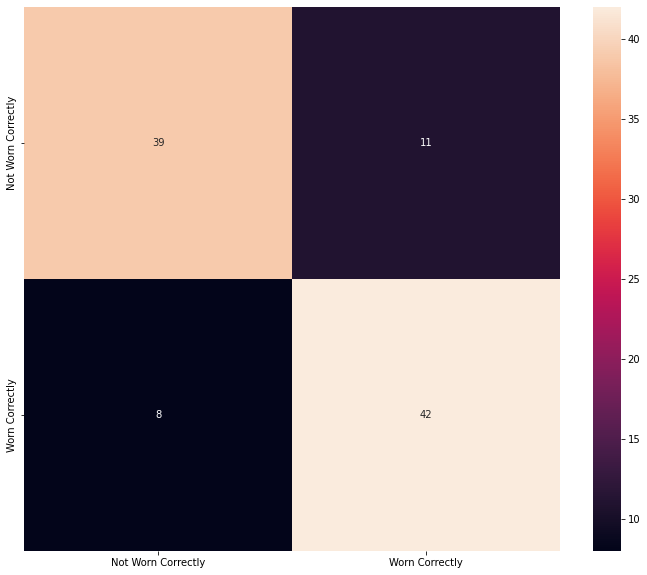

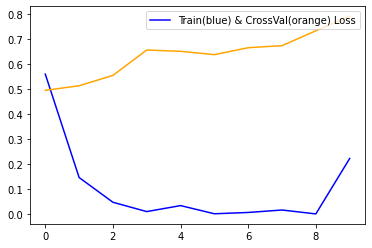

In [12]:
#finetune the model

model_path = 'inceptionv3_model_test'

model = finetuner.finetune_model(x_train, y_train, x_cv, y_cv, x_test, y_test,
                           model_path, lab2idx, batch_size=32, n_epochs=10)